In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import os
import pickle
import sys
import shutil
import yaml
import time
from enum import Enum
from crazyflie_helper import *
from argparse import ArgumentParser
from param_torch import Param, Timer
from environments import QuadrotorAirDrag, AirDragKernel2
import scipy.signal as signal
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [16]:
data = np.load('../crazyswarm/logs/icra2023_sysid/feature_learning_data/real/platey_circle_fast_seed38.npz')
print(data.files,data['adaptation_terms'].shape)
plt.plot(data['adaptation_terms'][:,1])

In [183]:
def load_cf_data2(filenames, takeofftime, hovertime, runtime, baseheight):
    data_dicts=[]

    for i in filenames:
        data = {}
        saved_data = dict(np.load(i, allow_pickle=True))

        minimum_len = np.inf
        for key in saved_data.keys():
            k = len(saved_data[key])
            if k<minimum_len:
                minimum_len = k
        
        for key in saved_data.keys():
            saved_data[key] = saved_data[key][:minimum_len]

        t_mask = (saved_data['ts'] > takeofftime + hovertime) * (saved_data['ts'] < runtime + takeofftime + hovertime)

        data['ts'] = saved_data['ts'][t_mask]
        data['ref_positions'] = saved_data['ref_positions'][t_mask] #- saved_data['ref_positions'][st]

        data['pose_positions'] = saved_data['pose_positions'][t_mask] #- saved_data['pose_positions'][st]
        data['pose_positions'][:, :2] -= data["ref_positions"][0, :2]
        data['pose_positions'][:, 2] -= baseheight

        data['ref_positions'][:, :2] -= data['ref_positions'][0, :2]
        data['ref_positions'][:, -1] -= baseheight

        data['pose_orientations_euler'] = saved_data['pose_orientations'][t_mask]
        
        rot_obj = R.from_euler('zyx', np.deg2rad(data['pose_orientations_euler']))
        data['pose_orientations_quat'] = rot_obj.as_quat()
        ft = []
        for t in range(len(t_mask)):
            if t_mask[t]:
                rot = R.from_euler('zyx', np.deg2rad(saved_data['pose_orientations'][t,:]))
                ft.append(rot.apply(np.array([0, 0, saved_data['thrust_cmds'][t]])))
        data['ft'] = np.array(ft)

        data['ref_orientation'] = saved_data['ref_orientation'][t_mask]
        data['thrust_cmds'] = saved_data['thrust_cmds'][t_mask]
        data['ang_vel_cmds'] = saved_data['ang_vel_cmds'][t_mask]
        data['L1_est'] = saved_data['adaptation_terms'][t_mask]
        
        data_dicts.append(data)
    
    return data_dicts

def convertDict2Array2(data_dicts,mass=1):
    batch_states = []
    batch_inputs = []
    batch_L1 = []
    batch_ft = []

    for i in range(len(data_dicts)):
        pos = data_dicts[i]["pose_positions"]
        dt = np.diff(data_dicts[i]["ts"])

        vel = np.diff(data_dicts[i]["pose_positions"], axis=0) / dt[:, None]
        vel = np.vstack((vel[0][None, :], vel))

        quat = data_dicts[i]["pose_orientations_quat"]

        if "pose_omega" in data_dicts[i]:
            omega = data_dicts[i]["pose_omega"]
        else:
            quat_diff = np.diff(quat, axis=0)
            omega = 2 * quat_diff[:, 1:] / dt[:, None]
            omega = np.vstack((omega[0][None, :], omega))

        quat = data_dicts[i]['ft']
        states_ = torch.tensor(np.hstack((pos, vel, quat, omega)), dtype=torch.float32)
        batch_states.append(states_)

        inputs_ = torch.tensor(mass*np.hstack((data_dicts[i]['thrust_cmds'][:,None],  np.deg2rad(data_dicts[i]['ang_vel_cmds']))), dtype=torch.float32)
        batch_inputs.append(inputs_)
        
        L1_ = torch.tensor(data_dicts[i]['L1_est'][:,1:], dtype=torch.float32)
        batch_L1.append(L1_)
        
        ft_ = torch.tensor(data_dicts[i]['ft'], dtype=torch.float32)
        batch_ft.append(ft_)
    return batch_states, batch_inputs, batch_L1, batch_ft

def load_data(files=None):
    takeofftime = 4.0
    baseheight = 1.0
    runtime = 14.0 #14.0
    hovertime = 0.0
    rootdir = '../crazyswarm/logs/icra2023_sysid/feature_learning_data/real/'
    fileNames = []
    for file in os.listdir(rootdir):
        if ".npz" in file:
            if files is None:
                fileNames.append(rootdir + file)
            elif file in files:
                fileNames.append(rootdir + file)
    data_dict = load_cf_data2(fileNames, takeofftime, hovertime, runtime, baseheight)
    states, inputs, L1_est, ft = convertDict2Array2(data_dict, mass=1)   
    return states, inputs, L1_est, ft, fileNames

In [ ]:
def L1_adaptation(self, v_t, f_t):
    dt = 0.02
    A = -0.2
    unit_mass = 1
    g_vec = np.array([0, 0, -1]) * 9.8
    alpha = 0.99
    phi = 1 / A * (np.exp(A * dt) - 1)

    a_t_hat = g_vec + f_t / unit_mass - self.wind_adapt_term_t + A * (self.v_hat - v_t)

    self.v_hat += a_t_hat * dt
    v_tilde = self.v_hat - v_t

    self.wind_adapt_term_t = 1 / phi * np.exp(A * dt) * v_tilde
    self.wind_adapt_term = -(1 - alpha) * self.wind_adapt_term_t + alpha * self.wind_adapt_term 

torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([697, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([700, 3])
torch.Size([698, 3])
torch.Size([6

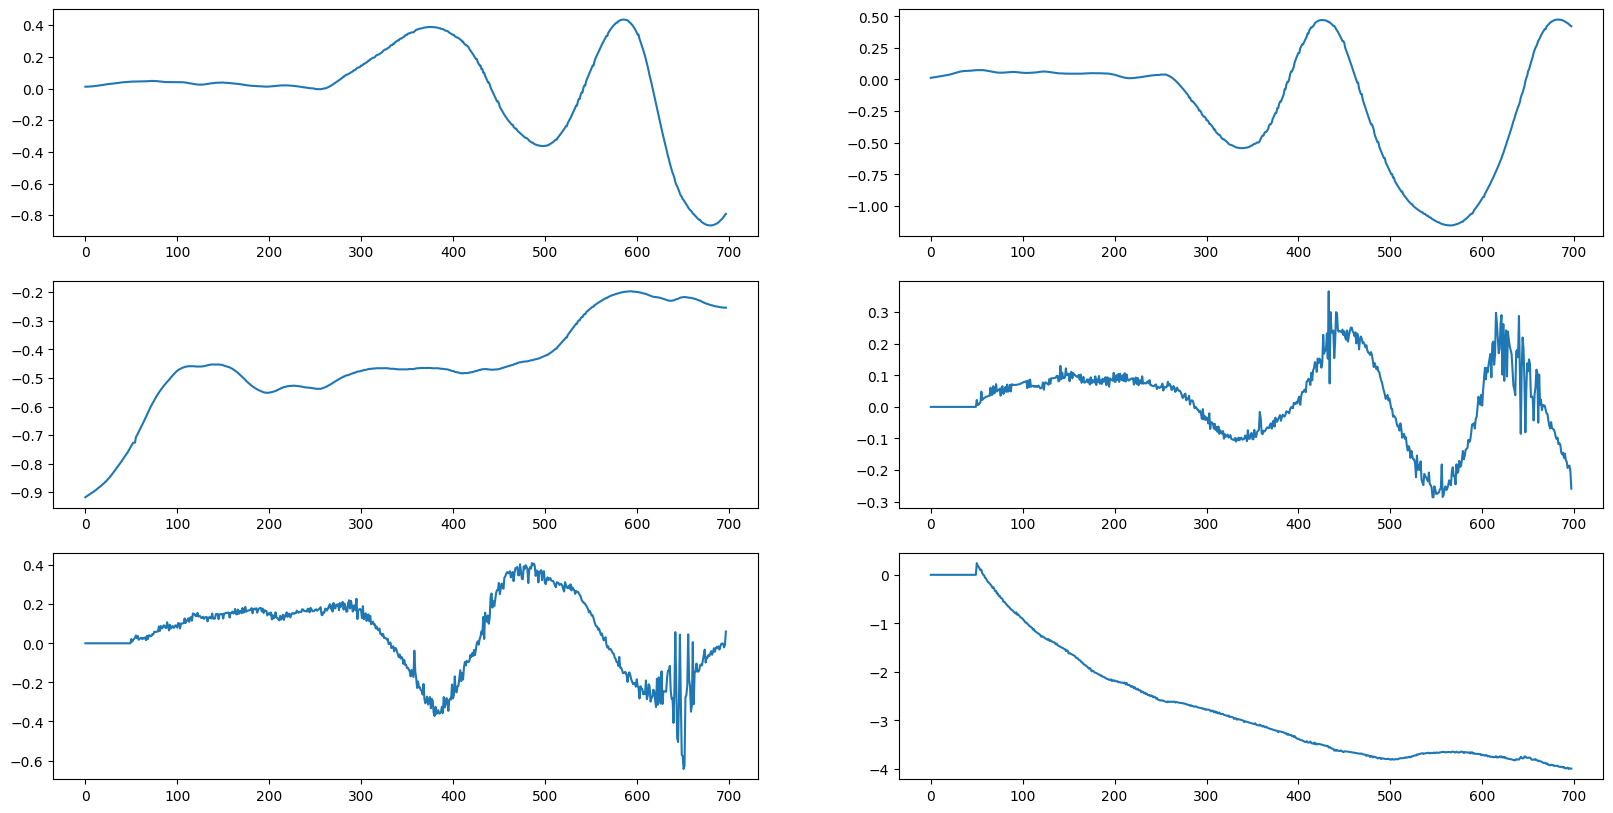

In [182]:
states, inputs, L1_est, _, _ = load_data()

idx = 28
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.plot(states[idx][:,0].cpu().detach().numpy())
plt.subplot(3,2,2)
plt.plot(states[idx][:,1].cpu().detach().numpy())
plt.subplot(3,2,3)
plt.plot(states[idx][:,2].cpu().detach().numpy())

plt.subplot(3,2,4)
plt.plot(L1_est[idx][:,0].cpu().detach().numpy())
plt.subplot(3,2,5)
plt.plot(L1_est[idx][:,1].cpu().detach().numpy())
plt.subplot(3,2,6)
plt.plot(L1_est[idx][:,2].cpu().detach().numpy())

In [184]:
class residual_net(torch.nn.Module):
    def __init__(self):
        dim_hidden = 32
        super(residual_net, self).__init__()
        self.fc1 = nn.Linear(6, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        #self.fc3 = nn.Linear(dim_hidden, dim_hidden)
        self.fc4 = nn.Linear(dim_hidden, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [187]:
class learn_features():
    def __init__(self, name):
        self.N_iters = 100000
        self.lr = 0.005 #0.005

        self.dim_out = 5
        #self.dim_hidden = 64 #64
        #self.dim_in = 7
        #self.num_hidden = 3

        self.idx1 = 0
        self.idx2 = 2

        self.update_A_interval = 1
        self.batch_size = 60
        self.gd_A = False
        self.print_interval = 10

        self.spectral_normalization = True

        # self.init_std = 0.1 #0.1
        # self.weights = [self.init_std * torch.randn(self.dim_out,self.dim_hidden)]
        # self.biases = [self.init_std * torch.randn(self.dim_out)]
        # for i in range(self.num_hidden):
        #   self.weights.append(self.init_std * torch.randn(self.dim_hidden,self.dim_hidden))
        #   self.biases.append(self.init_std * torch.randn(self.dim_hidden))
        # self.weights.append(self.init_std * torch.randn(self.dim_hidden,self.dim_in))
        # self.biases.append(self.init_std * torch.randn(self.dim_hidden))

        self.phi_fixed = AirDragKernel2()

        self.network = residual_net()

        # with open('./weights_checkpoint_sig', 'rb') as fp:
        #   data = pickle.load(fp)
        # self.weights = data[0]
        # self.biases = data[1]

        self.states, self.inputs, self.L1_est, _, _ = load_data()
        self.num_traj = len(self.states)
        self.indices = range(self.num_traj)
        self.Aest = []
        for i in range(self.num_traj):
            self.Aest.append([None,None])
        self.reg = 0.1

        self.update_Aest()

        self.id = name

    def train(self):
        #self.require_grads()
        loss_vals = []
        last100 = 0

        #criterion = self.compute_loss
        optimizer = torch.optim.Adam(self.network.parameters())

        for n in range(self.N_iters):
            traj_idx = np.random.choice(self.indices, size=self.batch_size, replace=False)
            #self.require_grads()
            optimizer.zero_grad()
            loss = self.compute_loss(traj_idx)
            loss.backward()
            optimizer.step()
            # grad = torch.autograd.grad(loss, self.get_params(traj_idx))
            # for i in range(len(self.weights)):
            #   self.weights[i] = self.weights[i] - self.lr * grad[i]
            #   self.biases[i] = self.biases[i] - self.lr * grad[i + self.num_hidden + 2]
            if self.gd_A:
                for i in range(self.batch_size):
                    self.Aest[traj_idx[i]] = self.Aest[traj_idx[i]] - self.lr * grad[2*self.num_hidden + 4 + i]
            if self.spectral_normalization:
                for param in self.network.parameters():
                    M = param.detach()
                    if M.ndim > 1:
                        u, s, vh = torch.svd(M)
                        if s[0] > 2: # 2
                            param.data = param / s[0] * 2
            last100 += loss.detach().cpu().numpy()

            if np.mod(n, self.update_A_interval) == 0 and not self.gd_A:
                #self.detach()
                self.update_Aest()
            if np.mod(n, self.print_interval) == 0 and n > 0:
                print(last100 / self.print_interval, n)
                loss_vals.append(last100 / self.print_interval)
                last100 = 0
            if np.mod(n, 200) == 0 and n > 0:
                torch.save(self.network.state_dict(),'./model_weights/' + self.id)
                plt.plot(loss_vals)
                plt.show()
                #plt.savefig('./loss_vals_new_' + self.id + '.png')
                #plt.close()

    def update_Aest(self):
        for i in range(self.num_traj):
            idx_split = int(self.states[i].shape[0] / 2)

            L1_p = self.L1_est[i][:idx_split-1,:][:,self.idx1:self.idx2]
            states_m = self.states[i][:idx_split-1,:]
            inputs_m = self.inputs[i][:idx_split-1,:]
            phi = self.inference(states_m)
            U,S,V = torch.linalg.svd(phi.T @ phi)
            Ahat_i = torch.linalg.inv(phi.T @ phi + self.reg * torch.eye(self.dim_out)) @ phi.T @ L1_p
            self.Aest[i][0] = Ahat_i.T

            L1_p = self.L1_est[i][idx_split-1:-1,:][:,self.idx1:self.idx2]
            states_m = self.states[i][idx_split-1:-1,:]
            inputs_m = self.inputs[i][idx_split-1:-1,:]
            phi = self.inference(states_m)
            Ahat_i = torch.linalg.inv(phi.T @ phi + self.reg * torch.eye(self.dim_out)) @ phi.T @ L1_p
            self.Aest[i][1] = Ahat_i.T

    def compute_loss(self, traj_idx):
        loss = 0
        for i in traj_idx:
            idx_split = int(self.states[i].shape[0] / 2)
            L1_p = self.L1_est[i][:idx_split-1,:][:,self.idx1:self.idx2]
            states_m = self.states[i][:idx_split-1,:]
            inputs_m = self.inputs[i][:idx_split-1,:]
            phi = self.inference(states_m).T
            loss = loss + torch.linalg.norm(L1_p.T - self.Aest[i][1] @ phi) ** 2

            L1_p = self.L1_est[i][idx_split-1:-1,:][:,self.idx1:self.idx2]
            states_m = self.states[i][idx_split-1:-1,:]
            inputs_m = self.inputs[i][idx_split-1:-1,:]
            phi = self.inference(states_m).T
            loss = loss + torch.linalg.norm(L1_p.T - self.Aest[i][0] @ phi) ** 2
        return loss / self.batch_size
        
    def inference(self, states):
        return self.network.forward(states[:,3:9])

    def activation(self, x):
        return torch.relu(x)

    def require_grads(self):
        for i in range(len(self.weights)):
            self.weights[i] = torch.autograd.Variable(self.weights[i], requires_grad=True)
        for i in range(len(self.biases)):
            self.biases[i] = torch.autograd.Variable(self.biases[i], requires_grad=True)

    def detach(self):
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i].detach()
        for i in range(len(self.biases)):
            self.biases[i] = self.biases[i].detach()
        for i in range(self.num_traj):
            self.Aest[i][0] = self.Aest[i][0].detach()

    def get_params(self,traj_idx):
        param = [*self.weights, *self.biases]
        if self.gd_A:
            for i in traj_idx:
                param.append(self.Aest[i])
        return param

22.290171813964843 10
17.521372604370118 20
16.929115867614748 30
16.61080093383789 40
16.263270473480226 50
15.877016067504883 60
15.721286201477051 70
15.5753737449646 80
15.407712268829346 90
15.272933197021484 100
15.100440216064452 110
14.882238006591797 120
14.76185655593872 130
14.56800889968872 140
14.327130985260009 150
14.194670104980469 160
14.003843402862548 170
13.857688808441162 180
13.538032150268554 190
13.655649757385254 200


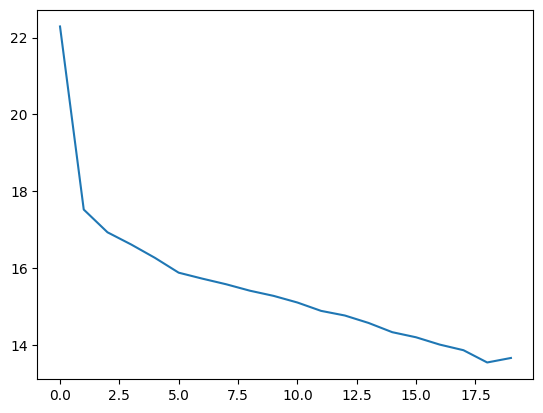

13.254536628723145 210
13.210488605499268 220
12.8563889503479 230
12.977091121673585 240
12.840028381347656 250
12.777160930633546 260
12.48007583618164 270
12.48937759399414 280
12.400460624694825 290
12.168005657196044 300
12.206008815765381 310
12.10652723312378 320
12.053345108032227 330
12.023769760131836 340
12.122869110107422 350
11.97509307861328 360
11.983957481384277 370
11.781202697753907 380
11.890042304992676 390
11.724628162384032 400


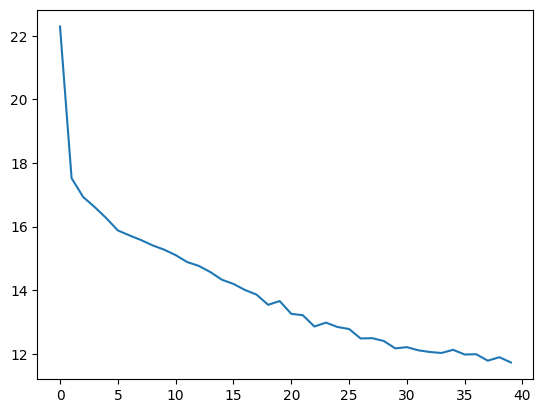

11.820766162872314 410
11.619478225708008 420
11.759170627593994 430
11.646738815307618 440
11.5640398979187 450
11.679357719421386 460
11.562141799926758 470
11.622649097442627 480
11.388707637786865 490
11.535638427734375 500
11.383966255187989 510
11.30074691772461 520
11.416677856445313 530
11.353220081329345 540
11.386122131347657 550
11.335094547271728 560
11.23381290435791 570
11.397283935546875 580
11.303720951080322 590
11.294470882415771 600


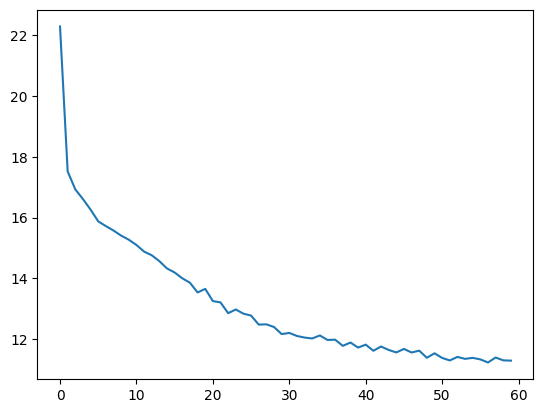

11.25480318069458 610
11.16014585494995 620
11.25881118774414 630
11.123618888854981 640
11.258244228363036 650
11.116678428649902 660
11.148369979858398 670
11.154595279693604 680
11.082832527160644 690
11.104912376403808 700
11.09518642425537 710
11.068993854522706 720
11.005290317535401 730
11.009358024597168 740
10.933392524719238 750
11.021006202697754 760
11.00933771133423 770
10.865121364593506 780
11.03906946182251 790
10.961578369140625 800


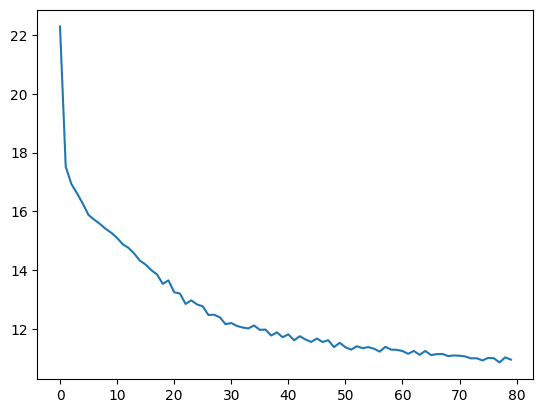

10.844034004211426 810
10.809247684478759 820
10.862010478973389 830
10.80771017074585 840
10.866479873657227 850
10.79631061553955 860
10.834274196624756 870
10.792198371887206 880
10.65600652694702 890
10.686561870574952 900
10.788725185394288 910
10.723576068878174 920
10.656001663208007 930
10.639084815979004 940
10.771272945404053 950
10.705960273742676 960
10.62286434173584 970
10.641960334777831 980
10.6173171043396 990
10.595639896392822 1000


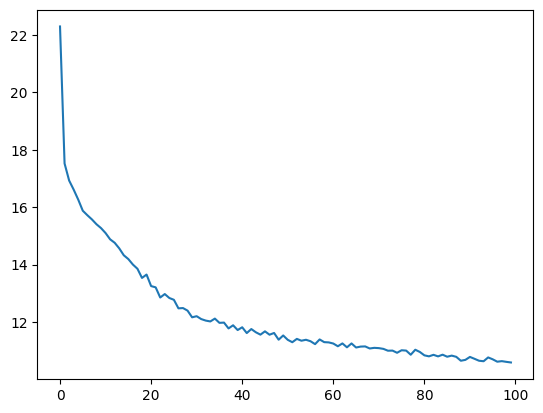

10.577526950836182 1010
10.623031997680664 1020
10.585460472106934 1030
10.600488662719727 1040
10.573592853546142 1050
10.580460262298583 1060
10.604622173309327 1070
10.345099544525146 1080
10.485952949523925 1090
10.416885471343994 1100
10.470603752136231 1110
10.435747337341308 1120
10.412641143798828 1130
10.468253898620606 1140
10.353331565856934 1150
10.409254932403565 1160
10.399629402160645 1170
10.418679237365723 1180
10.372344207763671 1190
10.38425121307373 1200


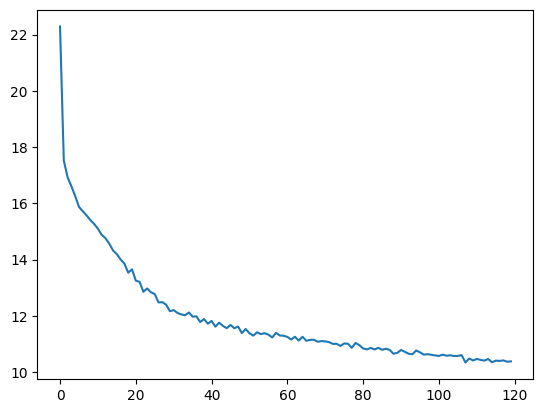

10.3842209815979 1210
10.329478645324707 1220
10.271390056610107 1230
10.404864311218262 1240
10.413009929656983 1250
10.322240734100342 1260
10.279191875457764 1270
10.35579309463501 1280
10.31102237701416 1290
10.209574508666993 1300
10.264758110046387 1310
10.285273456573487 1320
10.295864582061768 1330
10.311465740203857 1340
10.20762529373169 1350
10.228209018707275 1360
10.236533832550048 1370
10.162919330596925 1380
10.192862033843994 1390
10.177272319793701 1400


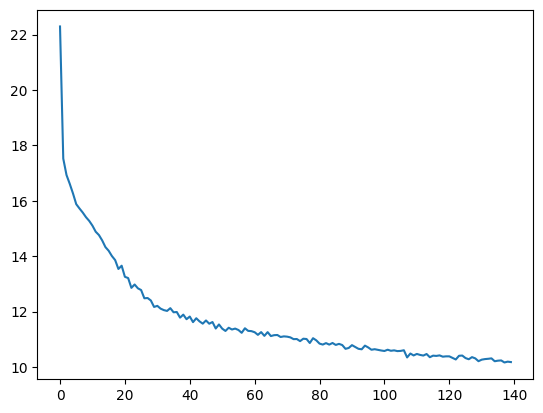

10.23913927078247 1410
10.261716079711913 1420
10.222099685668946 1430
10.30775499343872 1440
10.196660804748536 1450
10.25991449356079 1460
10.350749492645264 1470
10.281532955169677 1480
10.299903106689452 1490
10.326673030853271 1500
10.240488529205322 1510
10.327671718597411 1520
10.238769817352296 1530
10.33822603225708 1540
10.122153759002686 1550
10.367839813232422 1560
10.215956687927246 1570
10.233100700378419 1580
10.419644641876221 1590
10.240635681152344 1600


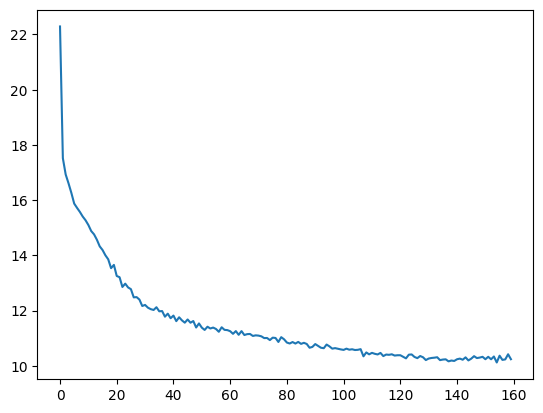

10.337761306762696 1610
10.37273473739624 1620
10.293099403381348 1630
10.322744846343994 1640
10.37826852798462 1650
10.382894515991211 1660
10.460145568847656 1670
10.459994125366212 1680
10.451722431182862 1690
10.42202024459839 1700
10.41693754196167 1710
10.482269382476806 1720
10.377459716796874 1730
10.382854747772218 1740
10.46926908493042 1750
10.439262199401856 1760
10.455734729766846 1770
10.447001934051514 1780
10.529441738128662 1790
10.46911325454712 1800


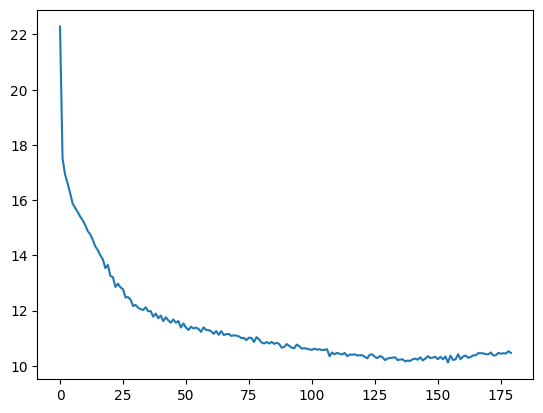

10.462363243103027 1810


KeyboardInterrupt: 

In [188]:
learn_feat = learn_features('L1_test_small_ft')
learn_feat.train()

../crazyswarm/logs/icra2023_sysid/feature_learning_data/real/circle_fanx-2_fany-0_seed18.npz
tensor([[-0.1077, -0.2212,  0.0720, -0.2859, -0.0534],
        [-0.0111, -0.3207, -0.0568,  0.3254, -0.2596],
        [-6.6537,  2.5427, -0.2127,  3.4860, -2.0030]],
       grad_fn=<PermuteBackward0>)
tensor([[ 1.3725e+00, -4.5816e-01,  1.0791e+00, -1.1009e+00,  4.7237e-01],
        [-4.6347e-01, -1.2056e+00, -7.1002e-01,  2.2658e-01,  2.3641e-02],
        [-1.4105e+00,  2.8245e+01,  8.7493e+00, -3.8758e-01, -1.5014e+01]],
       grad_fn=<PermuteBackward0>)


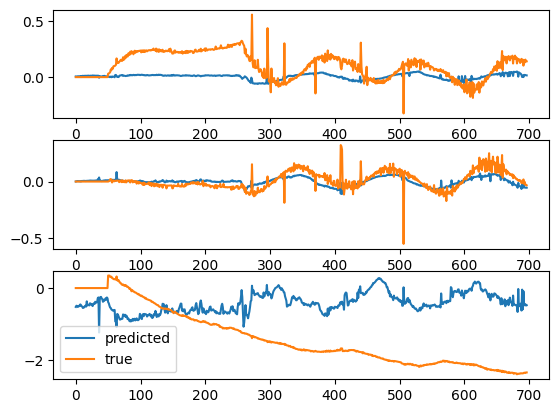

In [192]:
network = residual_net()
network.load_state_dict(torch.load('./model_weights/weights_new_checkpoint_L1_test_small_ft'))
filenames = ['chained_poly_fast_seed6.npz']
states, inputs, L1_est, _, filenames = load_data(files=filenames)

i = 0
#idx_split = int(states[i].shape[0] / 2)
idx_split = states[i].shape[0]

L1_p = L1_est[i][:idx_split-1,:].T
states_m = states[i][:idx_split-1,:]
inputs_m = inputs[i][:idx_split-1,:]
phi = network.forward(states_m[:,3:9])
U,S,V = torch.linalg.svd(phi.T @ phi)
Ahat_i = torch.linalg.inv(phi.T @ phi + 0.1 * torch.eye(5)) @ phi.T @ L1_p.T
Ahat_i = Ahat_i.T

# L1_p = L1_est[i][idx_split-1:-1,:].T
# states_m = states[i][idx_split-1:-1,:]
# inputs_m = inputs[i][idx_split-1:-1,:]
# phi = network.forward(states_m[:,3:10])
filenames = ['circle_fanx-2_fany-0_seed18.npz']
states, inputs, L1_est, _, filenames = load_data(files=filenames)
i = 0
#idx_split = states[i].shape[0]

L1_p = L1_est[i][:idx_split-1,:].T
states_m = states[i][:idx_split-1,:]
inputs_m = inputs[i][:idx_split-1,:]
phi = network.forward(states_m[:,3:9])
U,S,V = torch.linalg.svd(phi.T @ phi)
Ahat_i2 = torch.linalg.inv(phi.T @ phi + 0.1 * torch.eye(5)) @ phi.T @ L1_p.T
pred = Ahat_i @ phi.T

print(filenames[i])
print(Ahat_i)
print(Ahat_i2.T)

plt.subplot(3,1,1)
plt.plot(pred[0,:].cpu().detach().numpy(), label='predicted')
plt.plot(L1_p[0,:].cpu().detach().numpy(), label='true')
plt.subplot(3,1,2)
plt.plot(pred[1,:].cpu().detach().numpy(), label='predicted')
plt.plot(L1_p[1,:].cpu().detach().numpy(), label='true')
plt.subplot(3,1,3)
plt.plot(pred[2,:].cpu().detach().numpy(), label='predicted')
plt.plot(L1_p[2,:].cpu().detach().numpy(), label='true')
plt.legend()
plt.show()